In [10]:
from model.ResModule import RES
from model.ChannelAttention import ResModule
from utils.pixelShuffle_torch import pixel_shuffle
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import glob

In [11]:
class ImageDataset(Dataset):
    def __init__(self, ):
        self.path = "../MVFI_output/results/ucf_cslstm_20210116"
        self.number = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
        self.data_path = glob.glob(self.path+"/*/*/gt*")
        self.transform = transforms.Compose([
            transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
        ])
        
    def __getitem__(self, index):
        gt_path = self.data_path[index]
        input_path = gt_path.replace("gt", "pd")
        
        gt = self.transform(cv2.imread(gt_path))
        input_img = self.transform(cv2.imread(input_path))
        
        return gt, input_img
        
        
    def __len__(self):
        return len(self.data_path)

In [12]:
full_dataset = ImageDataset()
train_size = int(len(full_dataset)*0.8)
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [13]:
from torch.optim import Adam
from model import Criterion

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# CA_model = RES(n_resgroups=1, n_resblocks=3, n_channel=48, )
CA_model = ResModule(3, 48)
CA_model.to(device)

optimizer = Adam(CA_model.parameters(), lr=0.005)
criterion = Criterion.Loss()

In [16]:
for index, (gt, input_img) in enumerate(train_loader):
    downshuffled = pixel_shuffle(input_img.type(torch.cuda.FloatTensor), 1/4)
    gen = CA_model(downshuffled)
    upshuffled = pixel_shuffle(gen, 4)
    optimizer.zero_grad()
    loss, l1_loss, l2_loss = criterion(upshuffled, gt.type(torch.cuda.FloatTensor))
    if index % 10 == 0:
        print("Loss: {}".format(loss.cpu().detach().numpy()))
#         print("Loss1: {}".format(l1_loss.cpu().detach().numpy()))
#         print("Loss2: {}".format(l2_loss.cpu().detach().numpy()))
    loss.backward()
    optimizer.step()

Loss: 0.04643235728144646
Loss: 0.043735358864068985
Loss: 0.04367107152938843
Loss: 0.03999330848455429
Loss: 0.04264582693576813
Loss: 0.0461122989654541
Loss: 0.04480448365211487
Loss: 0.034644998610019684
Loss: 0.0343330018222332
Loss: 0.03660986199975014
Loss: 0.03550613671541214
Loss: 0.038417115807533264
Loss: 0.0427858904004097
Loss: 0.029868755489587784
Loss: 0.035608526319265366
Loss: 0.02972826361656189
Loss: 0.026124989613890648
Loss: 0.026557838544249535
Loss: 0.027943944558501244
Loss: 0.03357692062854767
Loss: 0.0329725407063961
Loss: 0.030781880021095276
Loss: 0.033358633518218994
Loss: 0.0318787544965744
Loss: 0.032310131937265396
Loss: 0.03299329802393913
Loss: 0.03804326802492142
Loss: 0.03364311531186104
Loss: 0.03366639465093613
Loss: 0.02747727558016777
Loss: 0.026658182963728905


In [ ]:
upshuffled

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(upshuffled.cpu().detach().numpy()[0], (1, 2, 0)))

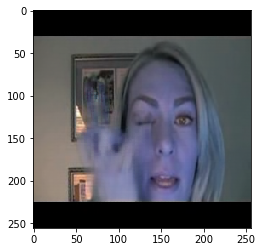

In [2]:
img = cv2.imread("../MVFI_output/results/ucf_3layer_cslstm_20210108/99/v_ApplyEyeMakeup_g24_c02.avi/pd-6.png")
img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_plt)

In [ ]:
CA_model = RES(n_resgroups=1, n_resblocks=3, n_channel=48, )
print(CA_model)

In [4]:
h, w, c = img.shape
img_tensor = np.reshape(img, (1, h, w, c))
img_tensor = np.transpose(img_tensor, (0, 3, 1, 2))
img_tensor = torch.from_numpy(img_tensor).type(torch.FloatTensor)

In [5]:
downshuffled = pixel_shuffle(img_tensor, 1/4)

In [ ]:
gen = CA_model(downshuffled)
np.shape(gen)

In [23]:
upshuffled = pixel_shuffle(gen, 4)
np.shape(upshuffled)

torch.Size([1, 3, 256, 256])